# Deep Neural Network for MNIST Classification

We'll apply all the knowledge from the lectures in this section to write a deep neural network. The problem we've chosen is referred to as the "Hello World" of deep learning because for most students it is the first deep learning algorithm they see.

The dataset is called MNIST and refers to handwritten digit recognition. You can find more about it on Yann LeCun's website (Director of AI Research, Facebook). He is one of the pioneers of what we've been talking about and of more complex approaches that are widely used today, such as covolutional neural networks (CNNs). 

The dataset provides 70,000 images (28x28 pixels) of handwritten digits (1 digit per image). 

The goal is to write an algorithm that detects which digit is written. Since there are only 10 digits (0, 1, 2, 3, 4, 5, 6, 7, 8, 9), this is a classification problem with 10 classes. 

Our goal would be to build a neural network with 2 hidden layers.

## Import the relevant packages

In [ ]:
# !pip install tensorflow-datasets

In [ ]:
# TensorFLow includes a data provider for MNIST.
# It comes with the tensorflow-datasets module -- install the packageimport numpy as np
# Datasets will be stored in C:\Users\*USERNAME*\tensorflow_datasets\...
# The first time you download a dataset, it is stored in the respective folder 
# Every other time, it is automatically loading the copy on your computer
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

## Data

That's where we load and preprocess our data.

In [ ]:
# tfds.load actually loads a dataset (or downloads and then loads if that's the first time you use it) 
# in our case, we are interesteed in the MNIST. The name of the dataset is the only mandatory argument
# with_info=True will also provide us with a tuple containing information about the version, features, number of samples
# as_supervised=True will load the dataset in a 2-tuple structure (input, target) 
# alternatively, as_supervised=False, would return a dictionary
# we will use this information a bit below and we will store it in mnist_info

mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)

# we can extract the training and testing dataset with the built references
mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']

# by default, TF has training and testing datasets, but no validation sets
# we must split it on our own
# we start by defining the number of validation samples as n% of the train samples
# this is also where we make use of mnist_info (we don't have to count the observations)
num_validation_samples = 0.1 * mnist_info.splits['train'].num_examples

# Set this number to an integer, as a float may cause an error
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

# Store the number of test samples in a dedicated variable
num_test_samples = mnist_info.splits['test'].num_examples

# Prefer an integer (rather than the default float)
num_test_samples = tf.cast(num_test_samples, tf.int64)

# We scale our data to make the result numerically stable
# In the case of MNIST we will simply prefer to have inputs between 0 and 1
# Define a function called "scale" that will take an MNIST image and its label
def scale(image, label):
    # we make sure the value is a float
    image = tf.cast(image, tf.float32)
    # The possible values for the inputs are 0 to 255 (256 different shades of grey)
    # If we divide each element by 255, we would get the desired result
    # all elements will be between 0 and 1 
    image /= 255.
    return image, label

# The method .map() allows us to apply a custom transformation to a given dataset
# We have already decided that we will get the validation data from mnist_train
scaled_train_and_validation_data = mnist_train.map(scale)

# Scale the test data
test_data = mnist_test.map(scale)

# Shuffle the data
# the BUFFER_SIZE parameter is here for cases with enormous datasets
# we can't shuffle the whole dataset in one go because we can't fit it all in memory
# instead TF only stores BUFFER_SIZE samples in memory at a time and shuffles them
# if BUFFER_SIZE=1 => no shuffling will actually happen
# there is a shuffle method available and we just need to specify the buffer size
BUFFER_SIZE = 10000
shuffled_train_and_validation_data = scaled_train_and_validation_data.shuffle(BUFFER_SIZE)

# extract the train and validation data set
# validation data would be equal to 10% of the training set
# we use the .take() method to take that many samples
# create a batch with a batch size equal to the total number of validation samples
validation_data = shuffled_train_and_validation_data.take(num_validation_samples)

# the train_data is everything else, so we skip as many samples as there are in the validation dataset
train_data = shuffled_train_and_validation_data.skip(num_validation_samples)

# determine the batch size
BATCH_SIZE = 100

# batch the train data
# this is helpful when we train, as we would be able to iterate over the different batches
train_data = train_data.batch(BATCH_SIZE)
validation_data = validation_data.batch(num_validation_samples)

# batch the test data
test_data = test_data.batch(num_test_samples)

# takes next batch (it is the only batch)
# because as_supervized=True, we've got a 2-tuple structure
validation_inputs, validation_targets = next(iter(validation_data))

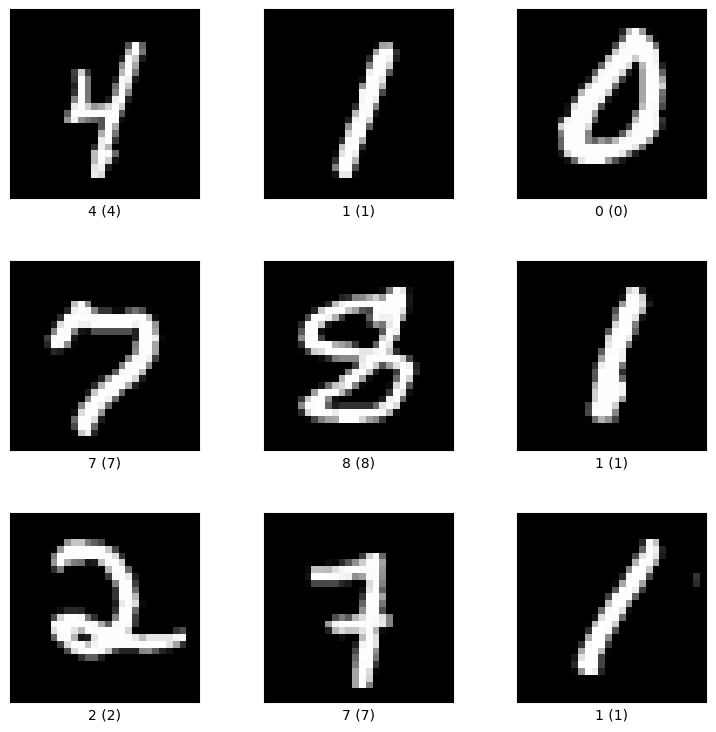

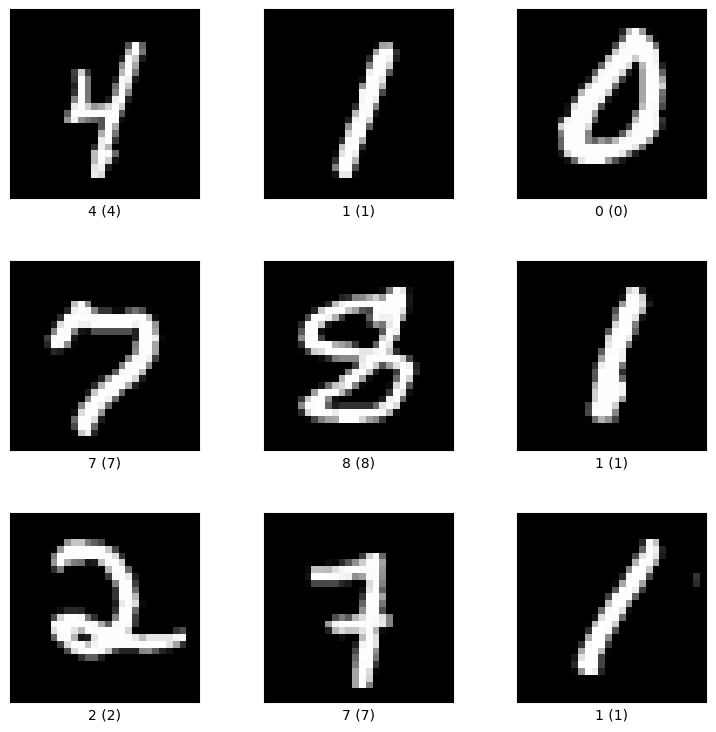

In [12]:
tfds.show_examples(mnist_train, mnist_info)

## Model

### Outline the model

In [ ]:
input_size = 784
output_size = 10

# Use same hidden layer size for both hidden layers. Not a necessity.
hidden_layer_size = 50
    
# define how the model will look like
model = tf.keras.Sequential([
    
    # the first layer (the input layer)
    # each observation is 28x28x1 pixels, therefore it is a tensor of rank 3
    # since we don't know CNNs yet, we must flatten the images
    # there is a convenient method 'Flatten' 
    # it takes our 28x28x1 tensor and orders it into a (28x28x1,) = (784,) vector
    # this allows us to actually create a feed forward neural network
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    
    # tf.keras.layers.Dense is basically implementing: 
    # output = activation(dot(input, weight) + bias)
    # most important arguments are the hidden_layer_size and the activation function
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 1st hidden layer
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 2nd hidden layer
    
    # the final layer is no different, we just make sure to activate it with softmax
    tf.keras.layers.Dense(output_size, activation='softmax') # output layer
])

In [13]:
# print a summary of the model to
# review how the network configuration and shape of the training data affect the nhe number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 50)                39250     
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
Total params: 42,310
Trainable params: 42,310
Non-trainable params: 0
_________________________________________________________________


### Choose the optimizer and the loss function

In [ ]:
# Define the optimizer,
# the loss function, 
# and the metrics we are interested in obtaining at each iteration
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Training
That's where we train the model we have built.

In [14]:
# Determine the maximum number of epochs
NUM_EPOCHS = 5

# Fit the model, 
# specify the training data
# the total number of epochs
# and the validation data we just created 
model.fit(train_data, epochs=NUM_EPOCHS, validation_data=(validation_inputs, validation_targets), validation_steps=10, verbose =2)

Epoch 1/5
540/540 - 1s - loss: 0.0804 - accuracy: 0.9757 - val_loss: 0.0875 - val_accuracy: 0.9742 - 1s/epoch - 2ms/step
Epoch 2/5
540/540 - 1s - loss: 0.0710 - accuracy: 0.9786 - val_loss: 0.0728 - val_accuracy: 0.9768 - 1s/epoch - 2ms/step
Epoch 3/5
540/540 - 1s - loss: 0.0601 - accuracy: 0.9816 - val_loss: 0.0680 - val_accuracy: 0.9792 - 1s/epoch - 2ms/step
Epoch 4/5
540/540 - 1s - loss: 0.0537 - accuracy: 0.9841 - val_loss: 0.0674 - val_accuracy: 0.9773 - 1s/epoch - 2ms/step
Epoch 5/5
540/540 - 1s - loss: 0.0491 - accuracy: 0.9854 - val_loss: 0.0635 - val_accuracy: 0.9785 - 1s/epoch - 2ms/step


## Test the model

As we discussed in the lectures, after training on the training data and validating on the validation data, we test the final prediction power of our model by running it on the test dataset that the algorithm has NEVER seen before.

It is very important to realize that fiddling with the hyperparameters overfits the validation dataset. 

The test is the absolute final instance. You should not test before you are completely done with adjusting your model.

If you adjust your model after testing, you will start overfitting the test dataset, which will defeat its purpose.

In [15]:
test_loss, test_accuracy = model.evaluate(test_data)

1/1 [==============================] - 0s 166ms/step - loss: 0.0987 - accuracy: 0.9702


In [16]:
# Apply some nice formatting
print('Test loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

Test loss: 0.10. Test accuracy: 97.02%


Using the initial model and hyperparameters given in this notebook, the final test accuracy should be roughly around 97%. Each time the code is rerun, we get a different accuracy as the batches are shuffled, the weights are initialized in a different way, etc.

Finally, we have intentionally reached a suboptimal solution:
- Try to optimize the NN with different hyperparameters (width, depth, etc.)

## Export the model

In [ ]:
# Call model.save to export the model's architecture, weights, and training configuration.
model.save('mnist_model/1', save_format='tf')

In [ ]:
# The saved model can be used as a starting point to share the trained model e.g.
# - via an online deployment
# - via a community (e.g. TensorFlow Hub, https://tfhub.dev/)